# Import necessary libraries

In [3]:
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import os
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

# Set styles for visualizations
plt.style.use('seaborn-v0_8-whitegrid')  # For matplotlib 3.6+
sns.set_palette("deep")
sns.set_style("whitegrid")


 # load data

In [2]:
# Load the data
def load_data():
    print("Loading datasets...")
    try:
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print(f"Train data shape: {train_df.shape}")
        print(f"Test data shape: {test_df.shape}")
        return train_df, test_df
    except FileNotFoundError as e:
        print(f"Error loading data: {e}")
        print("Please ensure the CSV files are in the current directory.")
        return None, None
        
# Load the data
train_df, test_df = load_data()


Loading datasets...
Train data shape: (1460, 81)
Test data shape: (1459, 80)


# Explore the data

In [3]:
# Define function for data exploration
def explore_data(df, is_train=True):
    print("\n----- Data Exploration " + ("(Training Data)" if is_train else "(Test Data)") + " -----")
    
    print("\nFirst 5 rows of the dataset:")
    print(df.head())
    
    print("\nDataset info:")
    buffer = []
    df.info(buf=buffer)
    info_str = "".join(buffer)
    print(info_str)
    
    if is_train:
        print("\nSummary statistics of numeric features:")
        print(df.describe().T)
        
        if 'SalePrice' in df.columns:
            print("\nSummary statistics of target variable (SalePrice):")
            print(df['SalePrice'].describe())
    
    print("\nChecking for missing values (columns with missing values):")
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    missing_data = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percent
    })
    print(missing_data[missing_data['Missing Values'] > 0].sort_values('Missing Values', ascending=False))
    
    return missing_values

# Explore training data
missing_train = explore_data(train_df, is_train=True)




----- Data Exploration (Training Data) -----

First 5 rows of the dataset:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0    

AttributeError: 'list' object has no attribute 'write'

In [5]:
# Identify feature columns related to square footage, bedrooms and bathrooms
def identify_columns(df):
    # Common column names for square footage
    sq_ft_columns = [col for col in df.columns if any(x in col.lower() for x in 
                   ['sqft', 'area', 'sf', 'footage', 'totalsf', 'grlivarea'])]
    
    # Common column names for bedrooms
    bedroom_columns = [col for col in df.columns if any(x in col.lower() for x in 
                      ['bed', 'bedrm', 'bedroom', 'bedroomabvgr'])]
    
    # Common column names for bathrooms
    bathroom_columns = [col for col in df.columns if any(x in col.lower() for x in 
                       ['bath', 'bthrm', 'bathroom', 'fullbath', 'halfbath', 'bsmtfullbath', 'bsmthalfbath'])]
    
    print("\nAutomatic column identification:")
    print(f"Square footage columns found: {sq_ft_columns}")
    print(f"Bedroom columns found: {bedroom_columns}")
    print(f"Bathroom columns found: {bathroom_columns}")
    
    return sq_ft_columns, bedroom_columns, bathroom_columns

# Identify columns
sq_ft_cols, bedroom_cols, bathroom_cols = identify_columns(train_df)



Automatic column identification:
Square footage columns found: ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea']
Bedroom columns found: ['BedroomAbvGr']
Bathroom columns found: ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']


# Data Preprocessing

In [6]:

def preprocess_data(train_df, test_df):
    print("\n----- Data Preprocessing -----")
    
    # Identify relevant columns
    sq_ft_cols, bedroom_cols, bathroom_cols = identify_columns(train_df)
    
    # Default column names to use if automatic identification fails
    default_sq_ft_col = 'GrLivArea' if 'GrLivArea' in train_df.columns else sq_ft_cols[0] if sq_ft_cols else None
    default_bedroom_col = 'BedroomAbvGr' if 'BedroomAbvGr' in train_df.columns else bedroom_cols[0] if bedroom_cols else None
    
    # For bathrooms, we'll try to add them up if we can find the columns
    bathroom_feature_created = False
    
    if 'FullBath' in train_df.columns and 'HalfBath' in train_df.columns:
        train_df['TotalBathrooms'] = train_df['FullBath'] + (0.5 * train_df.get('HalfBath', 0))
        test_df['TotalBathrooms'] = test_df['FullBath'] + (0.5 * test_df.get('HalfBath', 0))
        
        # Add basement bathrooms if available
        if 'BsmtFullBath' in train_df.columns:
            train_df['TotalBathrooms'] += train_df['BsmtFullBath']
            test_df['TotalBathrooms'] += test_df['BsmtFullBath']
        
        if 'BsmtHalfBath' in train_df.columns:
            train_df['TotalBathrooms'] += 0.5 * train_df['BsmtHalfBath']
            test_df['TotalBathrooms'] += 0.5 * test_df['BsmtHalfBath']
        
        bathroom_feature_created = True
    elif bathroom_cols:
        # If we couldn't add up the bathrooms but found a bathroom column, use the first one
        train_df['TotalBathrooms'] = train_df[bathroom_cols[0]]
        test_df['TotalBathrooms'] = test_df[bathroom_cols[0]]
        bathroom_feature_created = True
    
    # Check if we could identify all needed columns
    if not default_sq_ft_col or not default_bedroom_col or not bathroom_feature_created:
        print("Warning: Could not automatically identify all required columns.")
        print("Please specify the columns to use for square footage, bedrooms, and bathrooms.")
        return None, None, None, None
    
    # Select the features for modeling
    X_features = [default_sq_ft_col, default_bedroom_col, 'TotalBathrooms']
    
    # Check for missing values in selected features
    for col in X_features:
        if train_df[col].isnull().sum() > 0:
            print(f"Warning: Column {col} has {train_df[col].isnull().sum()} missing values.")
            print("Filling missing values with the median.")
            median_value = train_df[col].median()
            train_df[col].fillna(median_value, inplace=True)
            test_df[col].fillna(median_value, inplace=True)
    
    X_train = train_df[X_features]
    
    # Target variable is 'SalePrice'
    if 'SalePrice' not in train_df.columns:
        print("Error: Target variable 'SalePrice' not found in the dataset.")
        return None, None, None, None
    
    y_train = train_df['SalePrice']
    
    # Prepare test data
    X_test = test_df[X_features]
    
    print("\nSelected features:")
    print(f"Square footage: {default_sq_ft_col}")
    print(f"Bedrooms: {default_bedroom_col}")
    print(f"Bathrooms: TotalBathrooms (created from available bathroom columns)")
    
    print(f"\nTraining features shape: {X_train.shape}")
    print(f"Training target shape: {y_train.shape}")
    print(f"Test features shape: {X_test.shape}")
    
    # Create a directory for output
    os.makedirs('output', exist_ok=True)
    
    return X_train, y_train, X_test, X_features

# Preprocess the data
X_train, y_train, X_test, X_features = preprocess_data(train_df, test_df)



----- Data Preprocessing -----

Automatic column identification:
Square footage columns found: ['LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'PoolArea']
Bedroom columns found: ['BedroomAbvGr']
Bathroom columns found: ['BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath']

Selected features:
Square footage: GrLivArea
Bedrooms: BedroomAbvGr
Bathrooms: TotalBathrooms (created from available bathroom columns)

Training features shape: (1460, 3)
Training target shape: (1460,)
Test features shape: (1459, 3)


# Visualize the data


----- Data Visualization -----


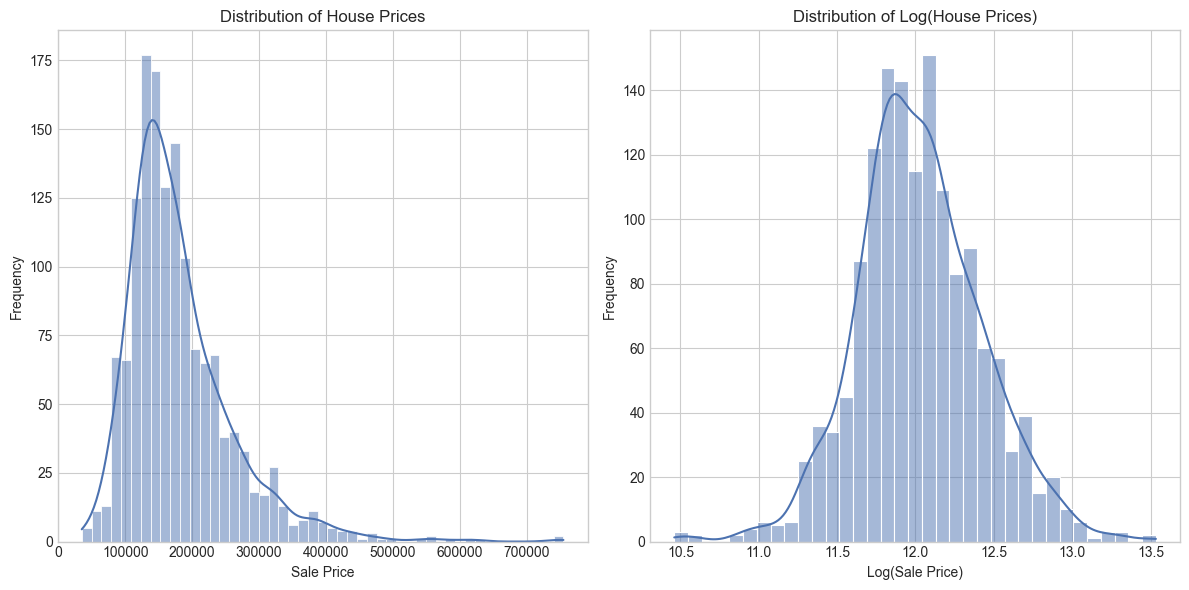

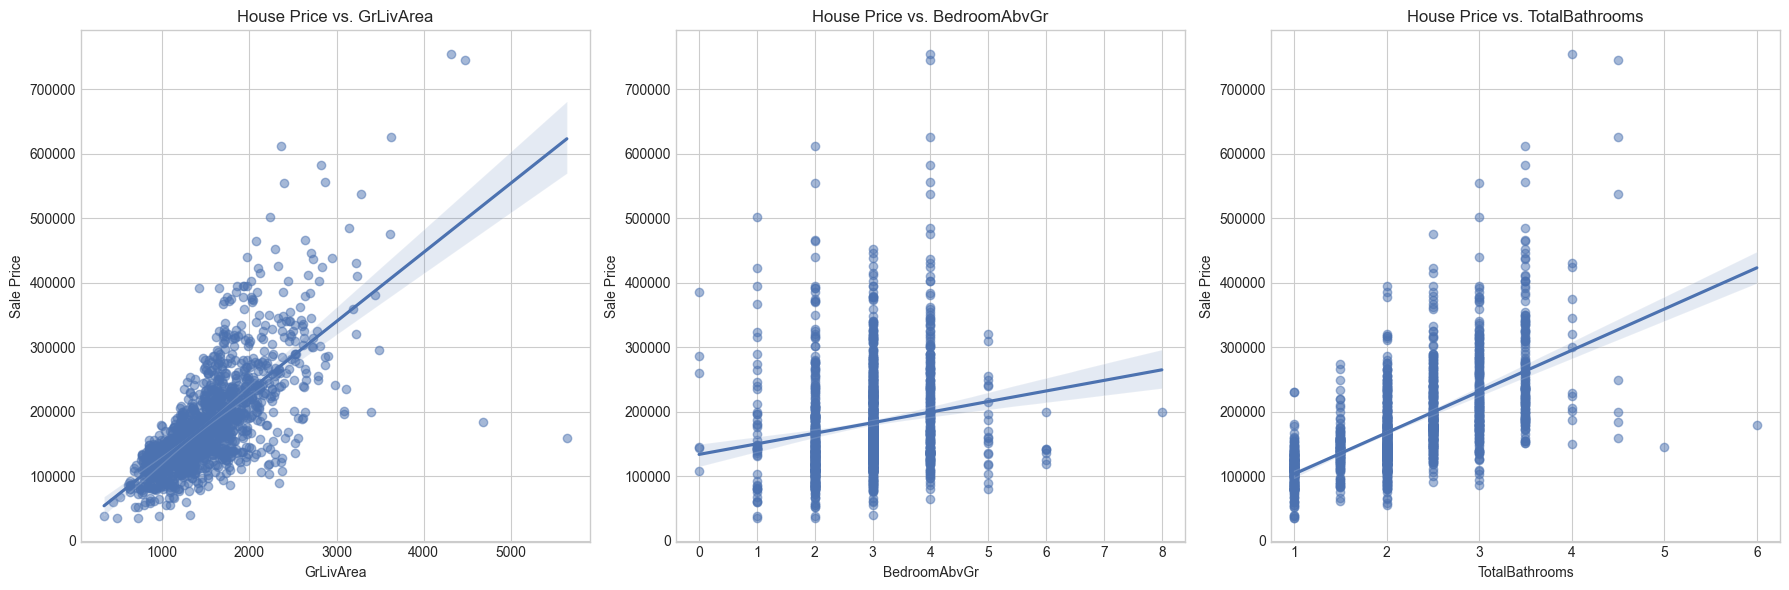

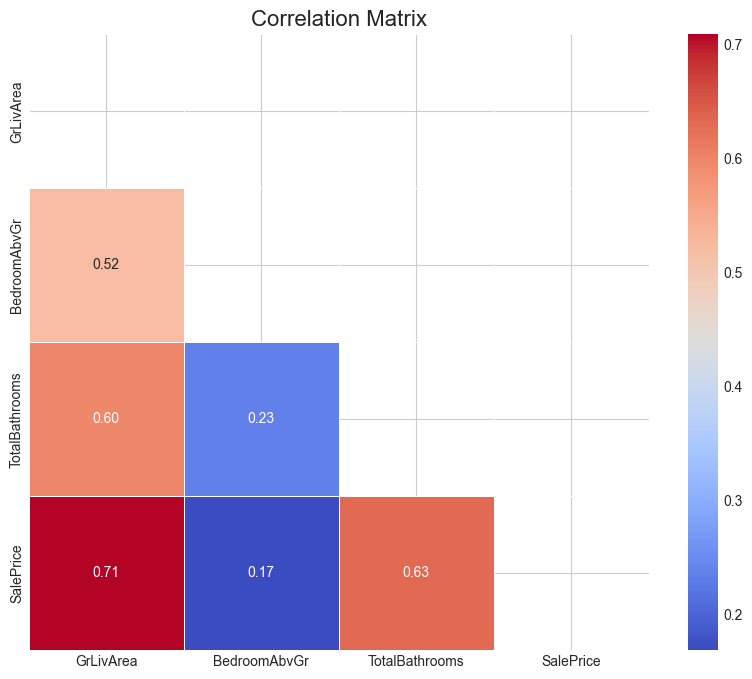

Visualizations saved to 'output' directory.


In [7]:

def visualize_data(X_train, y_train, feature_names):
    print("\n----- Data Visualization -----")
    
    # Create a dataframe for visualization
    viz_data = X_train.copy()
    viz_data['SalePrice'] = y_train
    
    # Plot the distribution of target variable
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(viz_data['SalePrice'], kde=True)
    plt.title('Distribution of House Prices')
    plt.xlabel('Sale Price')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    sns.histplot(np.log1p(viz_data['SalePrice']), kde=True)
    plt.title('Distribution of Log(House Prices)')
    plt.xlabel('Log(Sale Price)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('output/price_distribution.png')
    plt.show()
    
    # Plot the relationship between features and target
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # For each feature, create a scatter plot with regression line
    for i, feature in enumerate(feature_names):
        sns.regplot(x=feature, y='SalePrice', data=viz_data, ax=axes[i], scatter_kws={'alpha': 0.5})
        axes[i].set_title(f'House Price vs. {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Sale Price')
    
    plt.tight_layout()
    plt.savefig('output/feature_relationships.png')
    plt.show()
    
    # Correlation matrix
    plt.figure(figsize=(10, 8))
    correlation_matrix = viz_data.corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f',
                linewidths=0.5)
    plt.title('Correlation Matrix', fontsize=16)
    plt.savefig('output/correlation_matrix.png')
    plt.show()
    
    print("Visualizations saved to 'output' directory.")

# Visualize the data
visualize_data(X_train, y_train, X_features)


# Build the model


----- Building Model -----
Model Performance on Validation Set:
Mean Squared Error: 2623753007.35
Root Mean Squared Error: 51222.58
Mean Absolute Error: 34395.80
R² Score: 0.6579

Performing 5-fold cross-validation...
Cross-Validation RMSE Scores: [43609.02270498 48623.42888906 52234.3235633  44945.70296668
 58332.54932353]
Mean CV RMSE: 49549.01
Standard Deviation of CV RMSE: 5323.38

Model Coefficients:
GrLivArea: 49623.7676
BedroomAbvGr: -18700.3863
TotalBathrooms: 23513.7116
Intercept: 181441.5420

Regression Equation:
Price = 181441.54 + 49623.77 * GrLivArea - 18700.39 * BedroomAbvGr + 23513.71 * TotalBathrooms


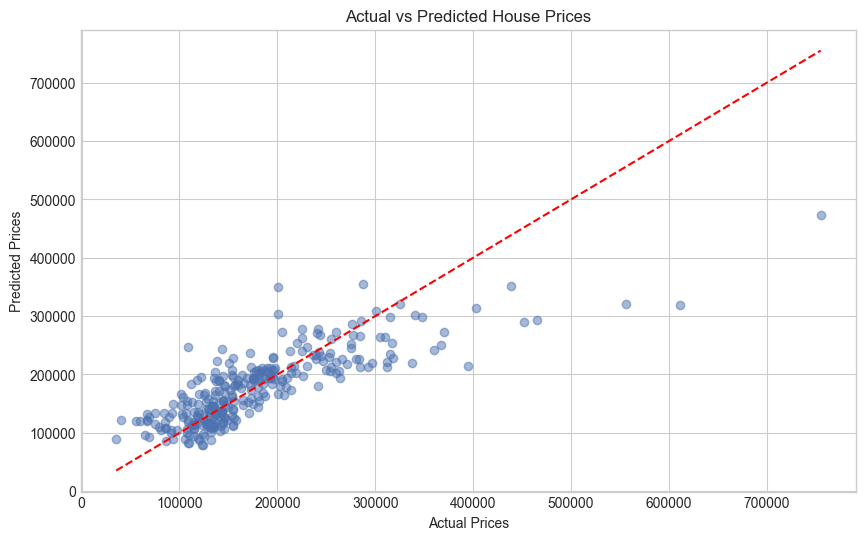

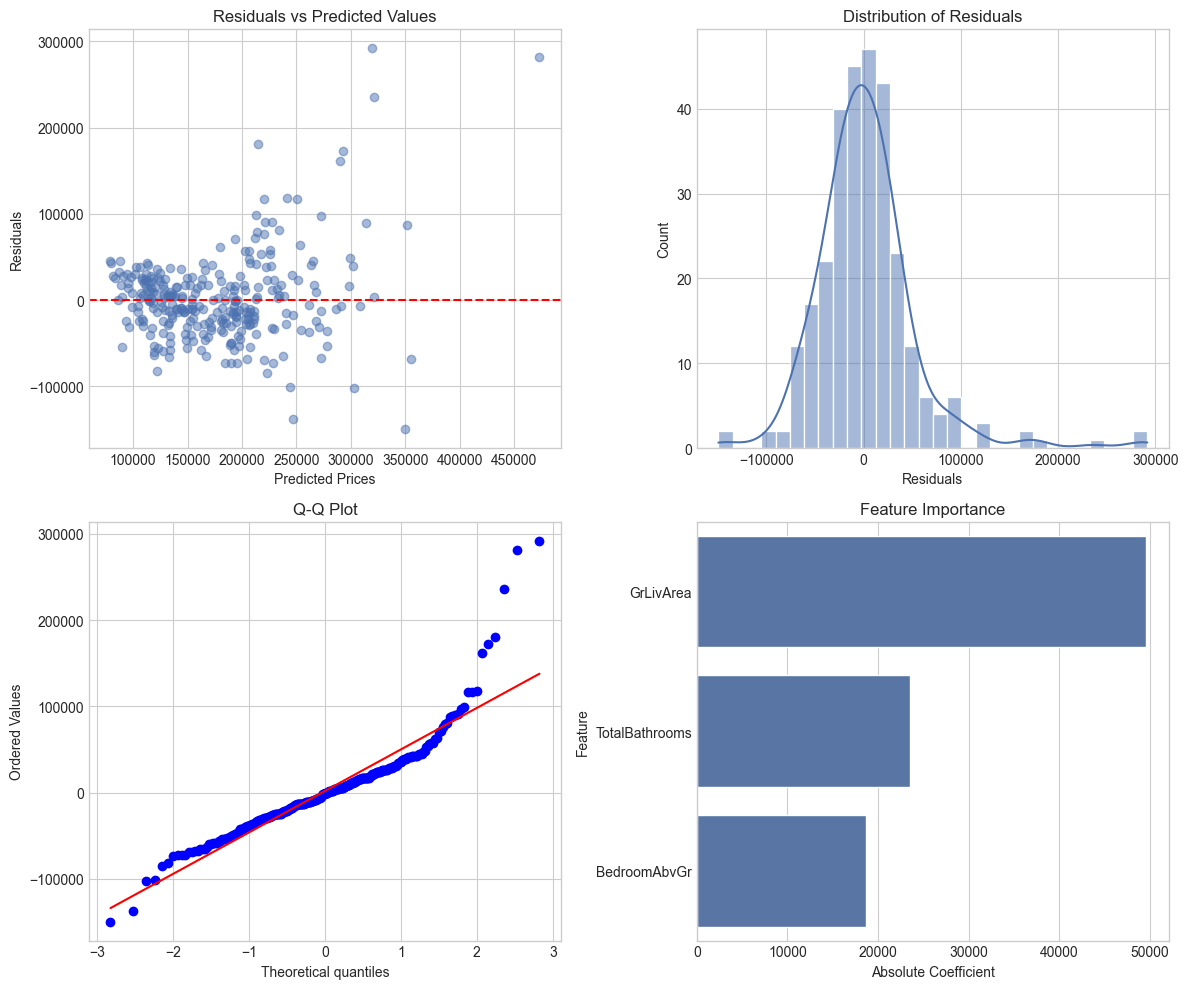

In [8]:

def build_model(X_train, y_train, feature_names):
    print("\n----- Building Model -----")
    
    # Split the training data for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(
        X_train, y_train, test_size=0.2, random_state=42
    )
    
    # Create a pipeline with preprocessing and model
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    
    # Train the model
    pipeline.fit(X_train_split, y_train_split)
    
    # Make predictions on validation set
    y_pred = pipeline.predict(X_val)
    
    # Evaluate the model
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    print(f"Model Performance on Validation Set:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"R² Score: {r2:.4f}")
    
    # Cross-validation
    print("\nPerforming 5-fold cross-validation...")
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse = np.sqrt(-cv_scores)
    
    print(f"Cross-Validation RMSE Scores: {cv_rmse}")
    print(f"Mean CV RMSE: {cv_rmse.mean():.2f}")
    print(f"Standard Deviation of CV RMSE: {cv_rmse.std():.2f}")
    
    # Print model coefficients
    model = pipeline.named_steps['model']
    print("\nModel Coefficients:")
    for feature, coef in zip(feature_names, model.coef_):
        print(f"{feature}: {coef:.4f}")
    print(f"Intercept: {model.intercept_:.4f}")
    
    # Create the regression equation
    equation = f"Price = {model.intercept_:.2f}"
    for feature, coef in zip(feature_names, model.coef_):
        sign = "+" if coef >= 0 else "-"
        equation += f" {sign} {abs(coef):.2f} * {feature}"
    
    print(f"\nRegression Equation:\n{equation}")
    
    # Visualize actual vs predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, y_pred, alpha=0.5)
    
    # Add perfect prediction line
    min_val = min(y_val.min(), y_pred.min())
    max_val = max(y_val.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.title('Actual vs Predicted House Prices')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.savefig('output/actual_vs_predicted.png')
    plt.show()
    
    # Residual analysis
    residuals = y_val - y_pred
    
    # Create a figure with multiple subplots for residual analysis
    plt.figure(figsize=(12, 10))
    
    # Residual vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted Values')
    plt.xlabel('Predicted Prices')
    plt.ylabel('Residuals')
    
    # Histogram of residuals
    plt.subplot(2, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    
    # QQ Plot
    plt.subplot(2, 2, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    
    # Feature importance
    plt.subplot(2, 2, 4)
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Absolute Coefficient': np.abs(model.coef_)
    }).sort_values('Absolute Coefficient', ascending=False)
    
    sns.barplot(x='Absolute Coefficient', y='Feature', data=feature_importance)
    plt.title('Feature Importance')
    
    plt.tight_layout()
    plt.savefig('output/residual_analysis.png')
    plt.show()
    
    return pipeline

# Build the model
model = build_model(X_train, y_train, X_features)


# Make predictions on test data

In [9]:

def make_predictions(model, X_test, test_df):
    print("\n----- Making Predictions on Test Data -----")
    
    # Generate predictions
    test_predictions = model.predict(X_test)
    
    # Create submission file
    submission = pd.DataFrame({
        'Id': test_df['Id'],
        'SalePrice': test_predictions
    })
    
    # Ensure predictions are positive
    submission['SalePrice'] = submission['SalePrice'].apply(lambda x: max(0, x))
    
    # Save to CSV
    submission.to_csv('output/house_price_predictions.csv', index=False)
    print("Predictions saved to 'output/house_price_predictions.csv'")
    
    # Show a sample of predictions
    print("\nSample of predictions:")
    print(submission.head())
    
    return submission

# Make predictions
submission = make_predictions(model, X_test, test_df)

print("\n======= Project Completed Successfully =======")
print("All outputs have been saved to the 'output' directory.")



----- Making Predictions on Test Data -----
Predictions saved to 'output/house_price_predictions.csv'

Sample of predictions:
     Id      SalePrice
0  1461  105484.725932
1  1462  138318.901052
2  1463  196896.156243
3  1464  194529.550118
4  1465  172013.777704

======= Project Completed Successfully =======
All outputs have been saved to the 'output' directory.
